In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from bvae import BVAE, bernoulli_log_prob

tfd = tfp.distributions

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  

data_dir = "/scratch/gf332/Misc/datasets/"

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
# Load datasets

mnist = tfds.load("mnist", data_dir=data_dir)
fashion_mnist = tfds.load("fashion_mnist", data_dir=data_dir)

In [4]:
!ls /scratch/gf332/Misc/bvae_experiments/fashion_mnist/vae

bernoulli_likelihood  gaussian_likelihood_with_softplus
gaussian_likelihood   latent_dim_20


In [5]:
vae_save_dir = "/scratch/gf332/Misc/bvae_experiments/fashion_mnist/vae/gaussian_likelihood_with_softplus/latent_dim_20"

In [6]:
latent_dim = 20

model = BVAE(latent_dim=latent_dim,
             likelihood="gaussian",
             prior_mode="weight_and_bias")
model.build(input_shape=(None, 28, 28, 1))

ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, vae_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)#.expect_partial()
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from /scratch/gf332/Misc/bvae_experiments/fashion_mnist/vae/gaussian_likelihood_with_softplus/latent_dim_20/ckpt-5515


In [7]:
def calculate_importance_lower_bound(model, batch, num_importance_samples):
    
    batch_size = batch.shape[0]
    
    latent_codes = model.posterior.sample(num_importance_samples)
    
    log_posterior_probs = tf.reduce_sum(model.posterior.log_prob(latent_codes), axis=2)
    log_prior_probs = tf.reduce_sum(model.prior.log_prob(latent_codes), axis=2)
    
    reconstructions = model.decoder(tf.reshape(latent_codes, [-1, model.latent_dim]))
    reconstructions = tf.reshape(reconstructions, [num_importance_samples, batch_size, 28, 28, 1])
    
    if model.likelihood == "gaussian":
        likelihood_dist = tfd.Normal(loc=reconstructions, scale=tf.nn.softplus(model.likelihood_log_scale))
        log_likelihoods = likelihood_dist.log_prob(batch)
        
    elif model.likelihood == "bernoulli":
        log_likelihoods = bernoulli_log_prob(mean=tf.nn.sigmoid(reconstructions),
                                             observation=batch)
    
    else:
        raise NotImplementedError
        
    log_likelihoods = tf.reduce_sum(log_likelihoods, axis=[2, 3, 4])
    
    log_importance_weights = log_likelihoods + log_prior_probs - log_posterior_probs
    
    importance_lower_bounds = tf.reduce_logsumexp(log_importance_weights, axis=0)
    
    return importance_lower_bounds

In [8]:
test_mnist = mnist["test"]
test_mnist = test_mnist.map(lambda x: tf.cast(x["image"], tf.float32) / 255.)

test_fashion_mnist = fashion_mnist["test"]
test_fashion_mnist = test_fashion_mnist.map(lambda x: tf.cast(x["image"], tf.float32) / 255.)

train_fashion_mnist = fashion_mnist["train"]
train_fashion_mnist = train_fashion_mnist.map(lambda x: tf.cast(x["image"], tf.float32) / 255.)

num_images = 1000

num_importance_samples = 50


for mnist_im, test_fashion_mnist_im, train_fashion_mnist_im in \
    zip(test_mnist.batch(num_images).take(1), 
        test_fashion_mnist.batch(num_images).take(1), 
        train_fashion_mnist.batch(num_images).take(1)):

    # Stuff for regular MNIST
    mnist_rec = model(mnist_im)
    
    mnist_elbos = model.data_log_likelihood
    mnist_elbos = mnist_elbos - tf.reduce_sum(tfd.kl_divergence(model.posterior, model.prior), axis=1)
    
    mnist_importance_lower_bounds = calculate_importance_lower_bound(model, mnist_im, num_importance_samples)
    

    # Stuff for test fashion MNIST
    test_fashion_mnist_rec = model(test_fashion_mnist_im)
    
    test_fashion_mnist_elbos = model.data_log_likelihood
    test_fashion_mnist_elbos = test_fashion_mnist_elbos - tf.reduce_sum(tfd.kl_divergence(model.posterior, model.prior), axis=1)
    
    test_fashion_mnist_importance_lower_bounds = calculate_importance_lower_bound(model, test_fashion_mnist_im, num_importance_samples)
    
     # Stuff for train fashion MNIST
    train_fashion_mnist_rec = model(train_fashion_mnist_im)
    
    train_fashion_mnist_elbos = model.data_log_likelihood
    train_fashion_mnist_elbos = train_fashion_mnist_elbos - tf.reduce_sum(tfd.kl_divergence(model.posterior, model.prior), axis=1)
    
    train_fashion_mnist_importance_lower_bounds = calculate_importance_lower_bound(model, train_fashion_mnist_im, num_importance_samples)

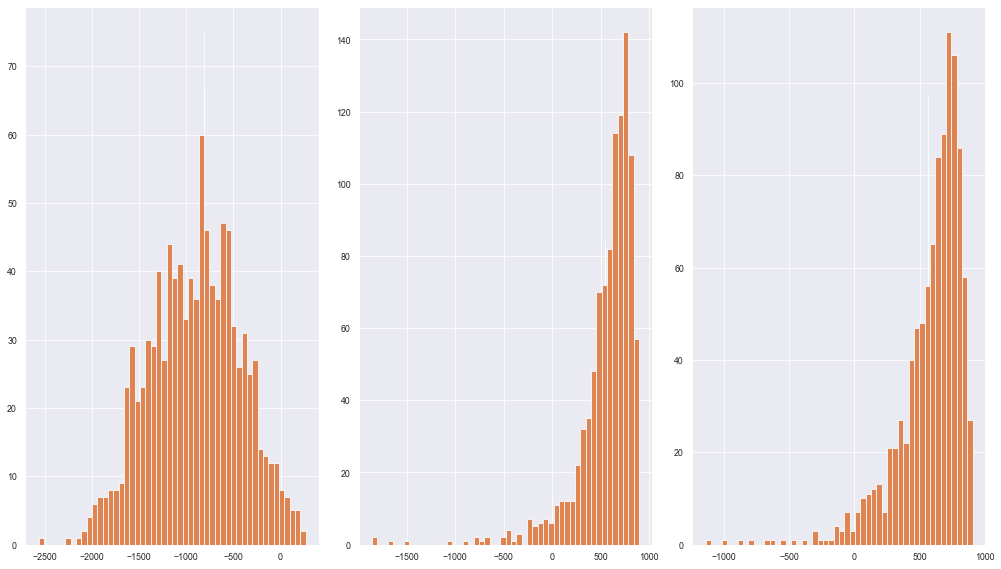

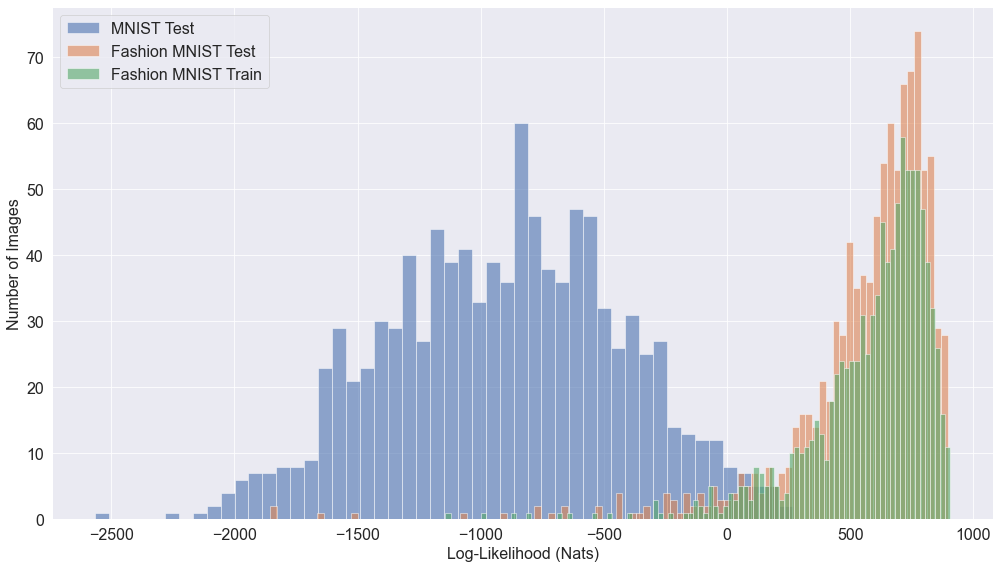

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 8))

ax1.hist(mnist_elbos, bins=50)
ax1.hist(mnist_importance_lower_bounds, bins=50)

ax2.hist(test_fashion_mnist_elbos, bins=50)
ax2.hist(test_fashion_mnist_importance_lower_bounds, bins=50)
fig.tight_layout()

ax3.hist(train_fashion_mnist_elbos, bins=50)
ax3.hist(train_fashion_mnist_importance_lower_bounds, bins=50)
fig.tight_layout()


fig, ax = plt.subplots(figsize=(14, 8))

ax.hist(mnist_importance_lower_bounds, bins=50, alpha=0.6, label="MNIST Test")
ax.hist(test_fashion_mnist_importance_lower_bounds, bins=100, alpha=0.6, label="Fashion MNIST Test")
ax.hist(train_fashion_mnist_importance_lower_bounds, bins=100, alpha=0.6, label="Fashion MNIST Train")

ax.set_xlabel("Log-Likelihood (Nats)", fontsize=16)
ax.set_ylabel("Number of Images", fontsize=16)
ax.legend(fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=16)

fig.tight_layout()

fig.savefig("../plots/mnist_vs_fashion_mnist_test_ll.png")

plt.show()